# Cognitive Age Prediction with MEG

In [1]:
import matplotlib.pyplot as plt
import mne
from mne.datasets import sample
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

from camcan.processing import SPoC
from camcan.utils import (plot_pred, plot_learning_curve,
                          plot_barchart, run_meg_ridge,
                          plot_error_age, plot_error_segments,
                          plot_boxplot, run_stacking)

%matplotlib inline

/storage/tompouce/okozynet/miniconda3/envs/mne/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
CV = 10
# store mae, std for the summary plot
meg_mae = {}
meg_mae_std = {}
meg_pred_diff = {}

## Read Data

In [3]:
subjects_data = pd.read_csv('../../data/participant_data.csv', index_col=0)
subjects_data.head()

,age,hand,gender_text,gender_code,tiv_cubicmm,cbuid700,cbuid280_sess1,cbuid280_sess2,cbuid280_sess3,cbuid280_sess4,profilecode,profilecode_numeric
Observations,,,,,,,,,,,,
CC110033,24,90.0,MALE,1,1413746.0,CBU120746,NaN,NaN,NaN,NaN,NaN,NaN
CC110037,18,89.0,MALE,1,1386581.0,CBU110544,NaN,NaN,NaN,NaN,NaN,NaN
CC110045,24,100.0,FEMALE,2,1385355.0,CBU111116,NaN,NaN,NaN,NaN,NaN,NaN
CC110056,22,100.0,FEMALE,2,1286849.0,CBU110547,NaN,CBU140153,CBU140224,NaN,D,1.0
CC110062,20,58.0,MALE,1,1582719.0,CBU110468,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# 643 subjects, each covariance is 9x306x306
meg_data = mne.externals.h5io.read_hdf5('../../data/covs_allch_oas.h5')

print(f'Found {len(meg_data)} subjects')
print(f'A covarince matrix shape is {meg_data[0]["covs"].shape}')

Found 643 subjects
A covarince matrix shape is (9, 306, 306)


## SPoC and Age Prediction

In [5]:
FREQ_BANDS = [(0.1, 1.5),  # low
              (1.5, 4.0),  # delta
              (4.0, 8.0),  # theta
              (8.0, 15.0),  # alpha
              (15.0, 26.0),  # beta_low
              (26.0, 35.0),  # beta_high
              (35.0, 50.0),  # gamma_low
              (50.0, 74.0),  # gamma_mid
              (76.0, 120.0)]  # gamma_high

Opening raw data file /home/okozynet/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Current compensation grade : 0
Fit was called
Transform was called
Transform was called
Fit was called
Transform was called
Transform was called
Fit was called
Transform was called
Transform was called
Fit was called
Transform was called
Transform was called
Fit was called
Transform was called
Transform was called
Fit was called
Transform was called
Transform was called
Fit was called
Transform was called
Transform was called
Fit was called
Transform was called
Transform was called
Fit was called
Transform was called
Transform was called
Fit was called
Transform was called
Transform was called
Fit was called
Transform was called
Transform w

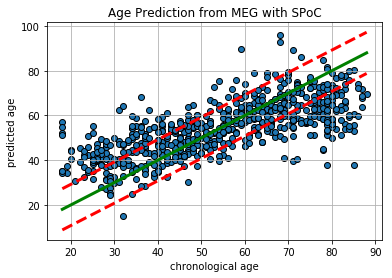

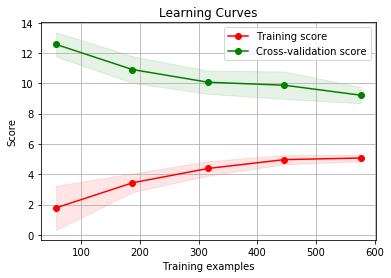

In [7]:
y, y_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores, _ = \
    run_meg_ridge(meg_data, subjects_data, alphas=np.logspace(-3, 5, 100), cv=CV, fbands=FREQ_BANDS)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

meg_mae['MEG-based Age Prediction'] = arr_mae
meg_mae_std['MEG-based Age Prediction'] = (mae, std)
meg_pred_diff['MEG-based Age Prediction'] = np.abs(y - y_pred)

plot_pred(y, y_pred, mae, title='Age Prediction from MEG with SPoC')
plot_learning_curve(train_sizes, train_scores, test_scores)

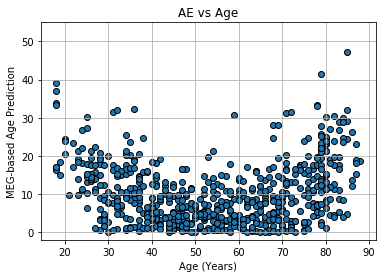

In [8]:
subjects = [d['subject'] for d in meg_data if 'subject' in d]
age_meg = subjects_data.loc[subjects].age.values

plot_error_age(meg_pred_diff, age_meg, ylim=(-2, 55))

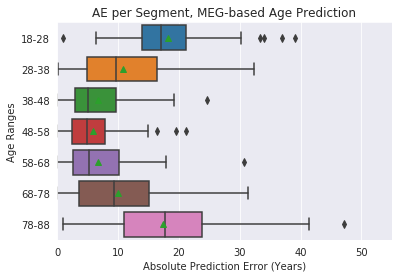

In [9]:
plot_error_segments(meg_pred_diff, age_meg, segment_len=10)

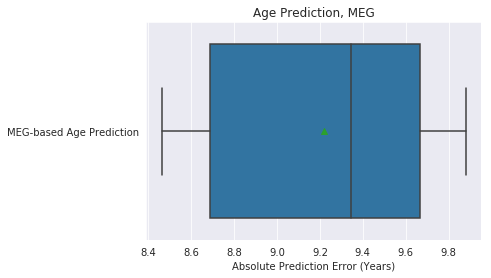

In [10]:
plot_boxplot(meg_mae, title='Age Prediction, MEG')

Results from the draft MAE : 8.878296175819491 (0.7210095297215949)

What to do next?

1. Stacking with MEG and MRI
2. ~~Plots as with MRI: boxplots - plot_boxplot, boxplots for errors - plot_error_segments - should be ranges, plot_error_age, do I need to have feature vs feature plots?~~
3. ~~Run code for MRI to check whether everything is fine after the previous merge~~
4. ~~Retreat project~~

## Stacking

In [6]:
# read data of other predictors
area_data = pd.read_hdf('../../data/structural/structural_data.h5', 
                           key='area')
thickness_data = pd.read_hdf('../../data/structural/structural_data.h5',
                               key='thickness')
volume_data = pd.read_hdf('../../data/structural/structural_data.h5',
                            key='volume')

area_data = area_data.dropna()
thickness_data = thickness_data.dropna()
volume_data = volume_data.dropna()

connect_data_tangent_basc = pd.read_hdf('../../data/connectivity/connect_data_tangent.h5',
                              key='basc197')
connect_data_tangent_modl = pd.read_hdf('../../data/connectivity/connect_data_tangent.h5',
                              key='modl256')

In [7]:
multimodal_data = [('area', area_data), ('thickness', thickness_data), ('volume', volume_data),
                   ('basc', connect_data_tangent_basc), ('modl', connect_data_tangent_modl),
                   ('meg', meg_data)]

y, y_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores, _ \
    = run_stacking(multimodal_data, subjects_data, cv=CV, fbands=FREQ_BANDS)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

multimodal_mae_std['Stacked-multimodal'] = (mae, std)
multimodal_mae['Stacked-multimodal'] = arr_mae
multimodal_pred_diff['Stacked-multimodal'] = np.abs(y - y_pred)

plot_pred(y, y_pred, mae, title='Age Prediction, Stacked-multimodal')
plot_learning_curve(train_sizes, train_scores, test_scores)

Opening raw data file /home/parietal/okozynet/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Current compensation grade : 0
MAE: 4.97
MAE STD: 0.43


NameError: name 'multimodal_mae_std' is not defined

In [9]:
'CC110174' in area_data.index.values

True

In [ ]:
 # read sample data to prepare picks for epochs
from mne.datasets import sample
from camcan.processing import SPoC

fbands = FREQ_BANDS

data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
raw = mne.io.read_raw_fif(raw_fname)
info = raw.info
picks = mne.pick_types(info, meg='mag')

subjects = [d['subject'] for d in meg_data if 'subject' in d]
covs = np.array(tuple(d['covs'][:, picks][:, :, picks] for d in meg_data if 'subject' in d))

# prepare data, subjects age
y = subjects_data.loc[subjects].age.values
X = np.arange(len(y))

spoc = SPoC(covs=covs, fbands=fbands, spoc=True, n_components=len(picks), alpha=0.01)


In [ ]:
y = subjects_data.loc[subjects].age.values
X = np.arange(len(y))

In [ ]:
X.shape

In [11]:
[i if i != 2 else 20 for i in [0, 1, 2]]

[0, 1, 20]